This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Hydrometeorclassification

In [1]:
import wradlib as wrl
import xarray as xr
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
from scipy import interpolate
import datetime as dt
import glob

The hydrometeorclassification code is based on the paper by [Zrnic et.al 2001](https://dx.doi.org/10.1175/1520-0426%282001%29018%3C0892:TAPFAC%3E2.0.CO;2) utilizing 2D trapezoidal membership functions based on the paper by [Straka et. al 2000](https://doi.org/10.1175/1520-0450(2000)039%3C1341:BHCAQU%3E2.0.CO;2) adapted by [Evaristo et. al 2013](https://ams.confex.com/ams/36Radar/webprogram/Paper229078.html) for X-Band.

## Precipitation Types

In [2]:
pr_types = wrl.classify.pr_types
for k, v in pr_types.items():
    print(str(k) + " - ".join(v))

0LR - Light Rain
1MR - Moderate Rain
2HR - Heavy Rain
3LD - Large Drops
4HL - Hail
5RH - Rain/Hail
6GH - Graupel/Hail
7DS - Dry Snow
8WS - Wet Snow
9HC - H Crystals
10VC - V Crystals
11NP - No Precip


## Membership Functions

### Load 2D Membership Functions

In [3]:
filename = wrl.util.get_wradlib_data_file("misc/msf_xband_v1.nc")
msf = xr.open_dataset(filename)
display(msf)

<xarray.Dataset>
Dimensions:  (idp: 55, hmc: 11, trapezoid: 4)
Coordinates:
  * idp      (idp) float64 -10.0 -8.0 -6.0 -4.0 -2.0 ... 92.0 94.0 96.0 98.0
  * hmc      (hmc) object 'LR' 'MR' 'HR' 'LD' 'HL' 'RH' 'GH' 'DS' 'WS' 'HC' 'VC'
Dimensions without coordinates: trapezoid
Data variables:
    ZH       (hmc, idp, trapezoid) float64 ...
    ZDR      (hmc, idp, trapezoid) float64 ...
    RHO      (hmc, idp, trapezoid) float64 ...
    KDP      (hmc, idp, trapezoid) float64 ...
    TEMP     (hmc, idp, trapezoid) float64 ...
Attributes:
    version:      1
    title:        2D Membershipfunctions Hydrometeorclassification for XBand
    institution:  Institute of Geosciences, Meteorology Section, University o...
    history:      created by Raquel Evaristo, adapted to netCDF by Kai Mühlbauer
    comment:      created with wradlib

### Plot 2D Membership Functions

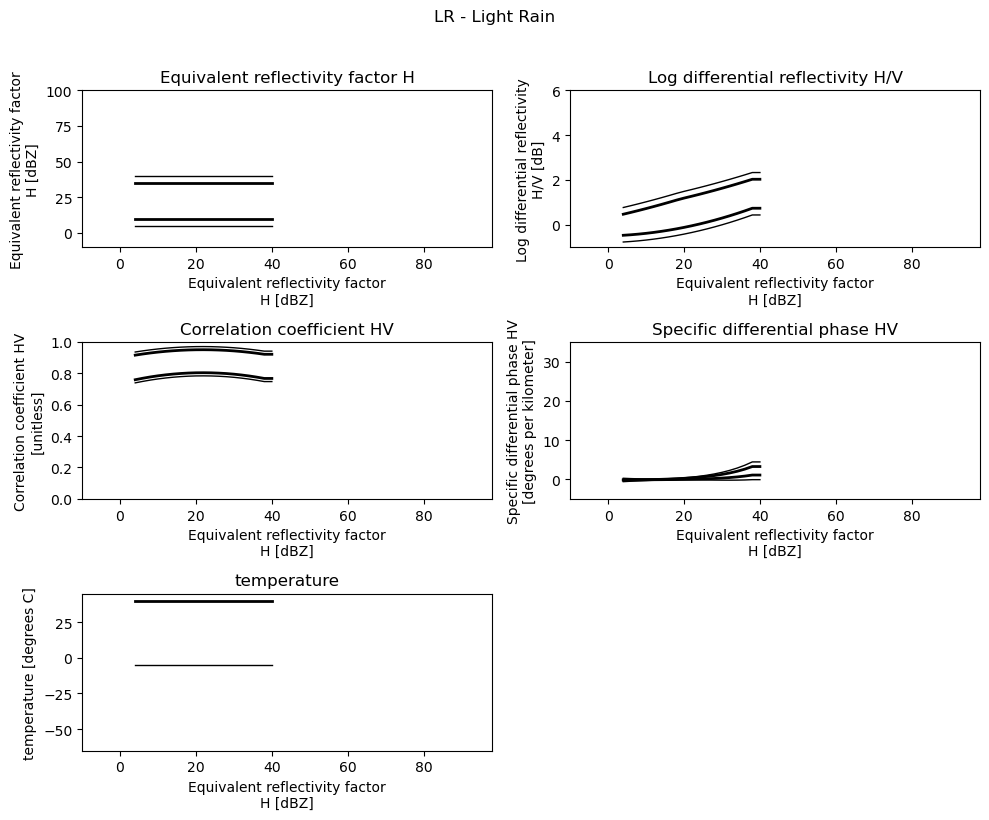

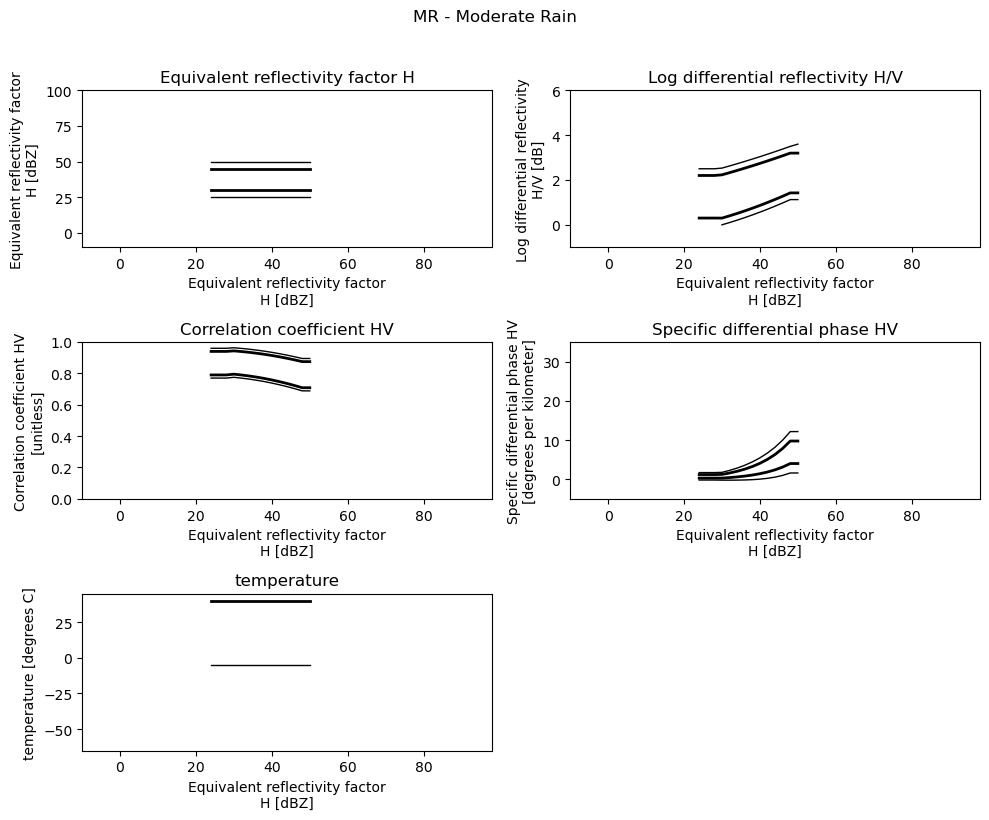

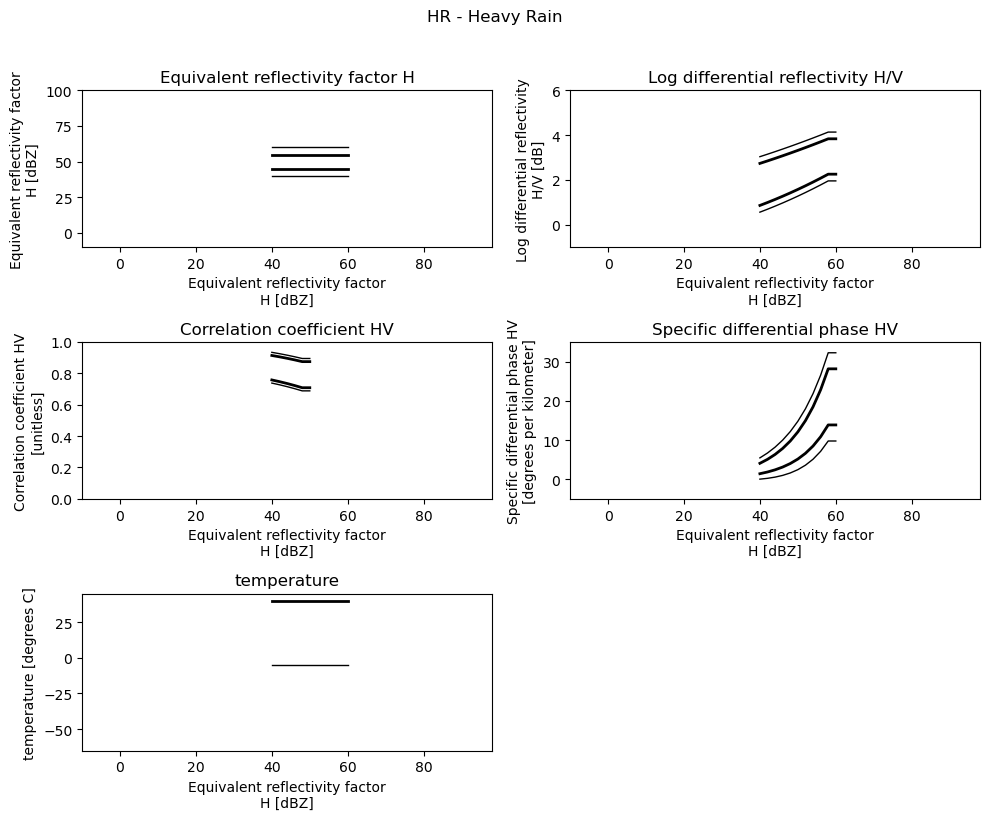

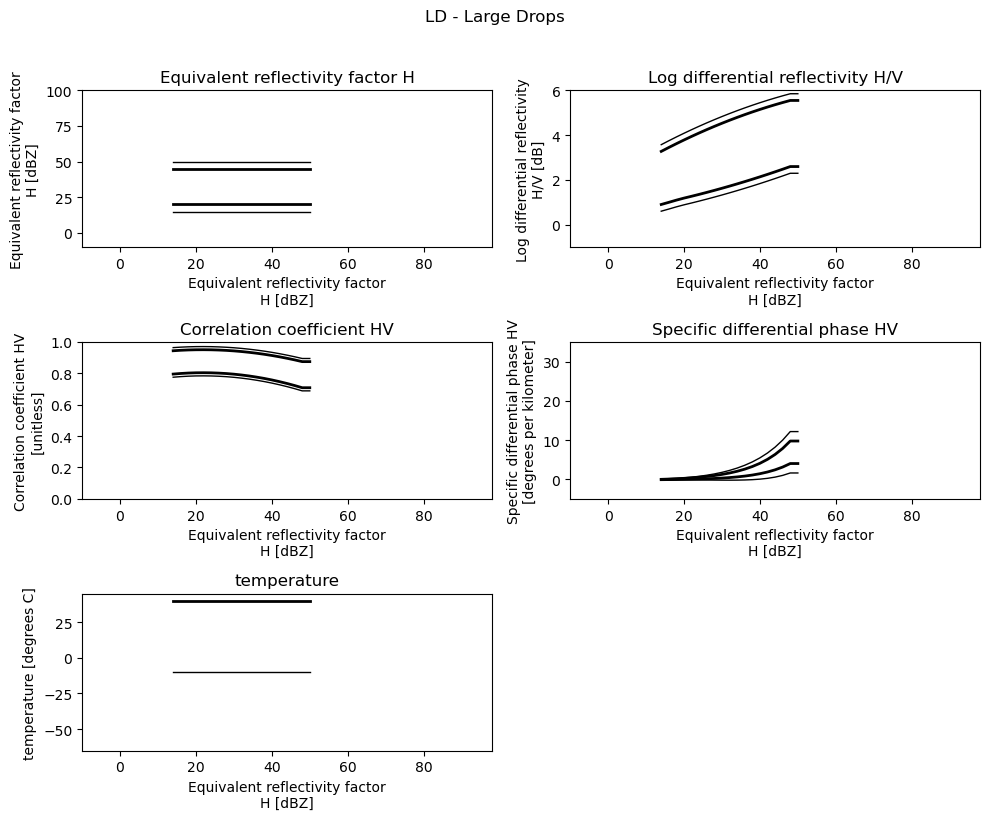

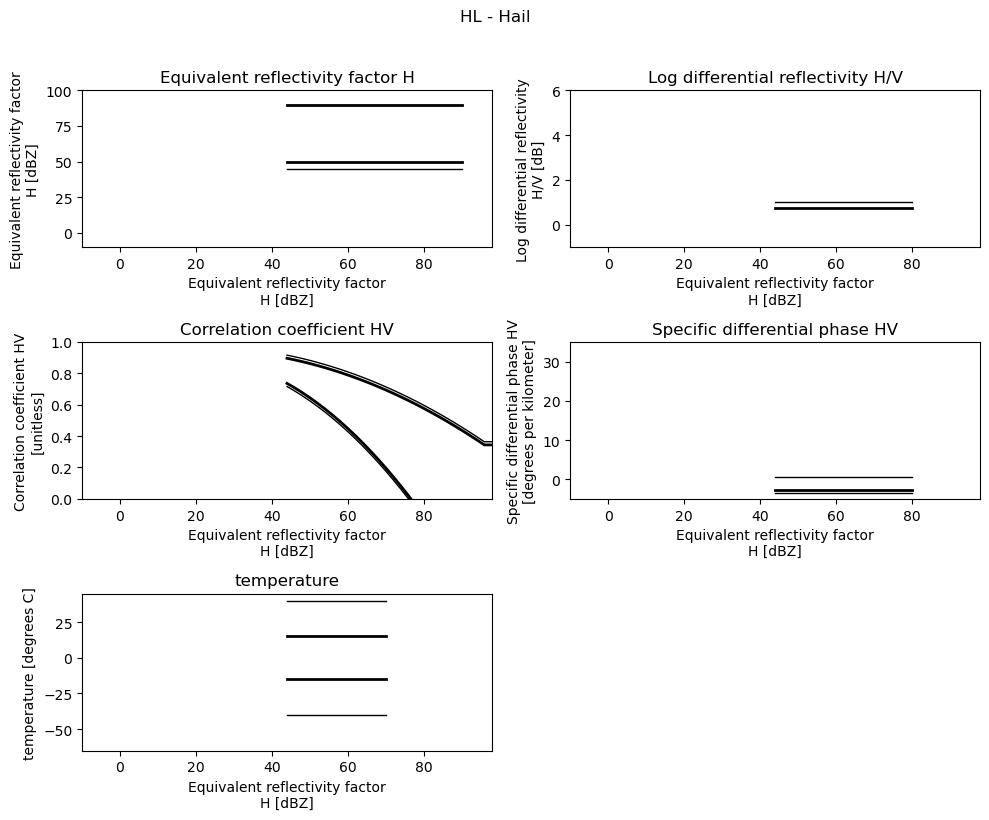

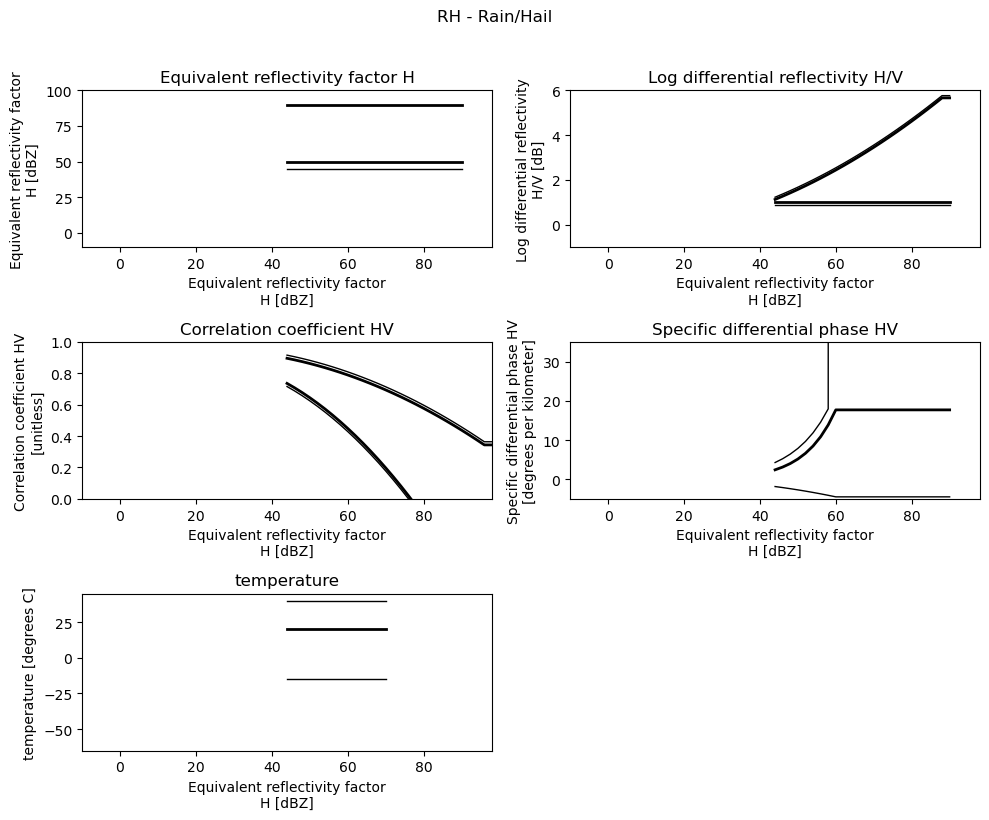

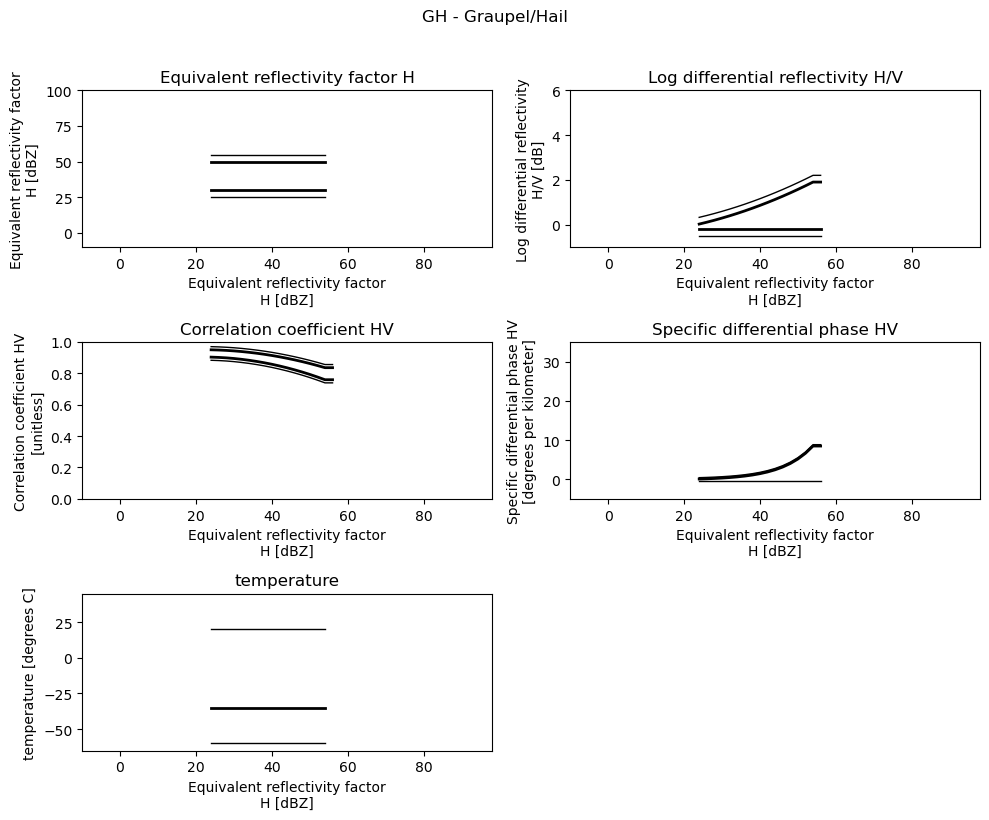

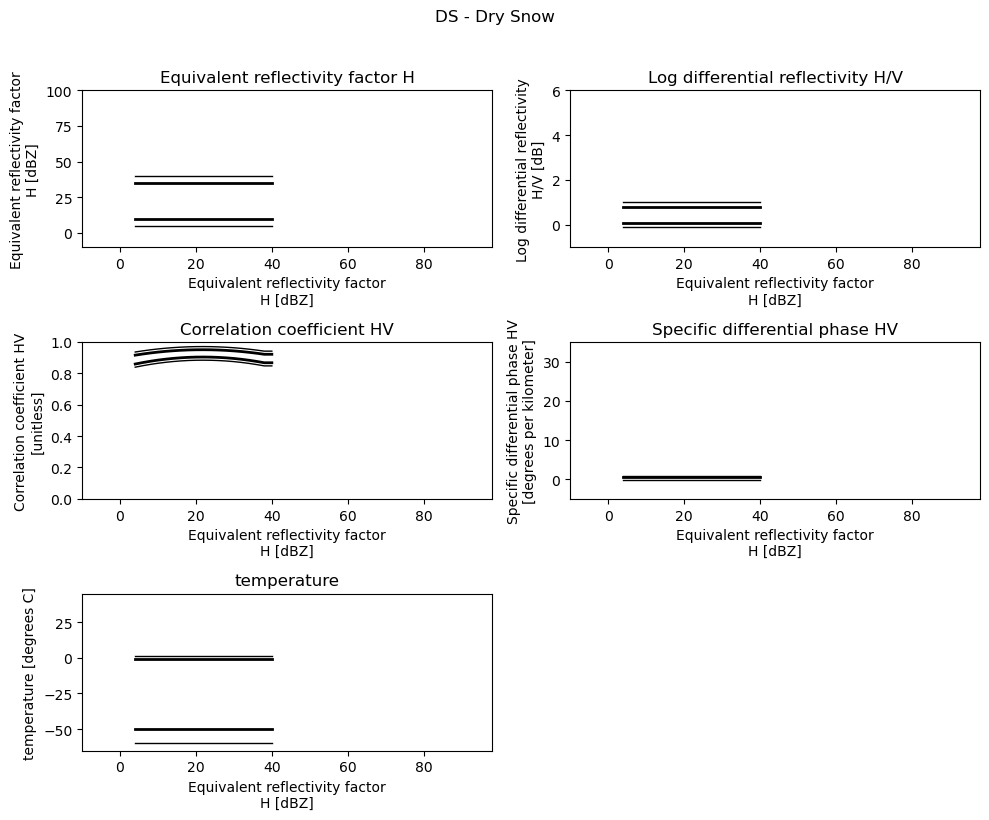

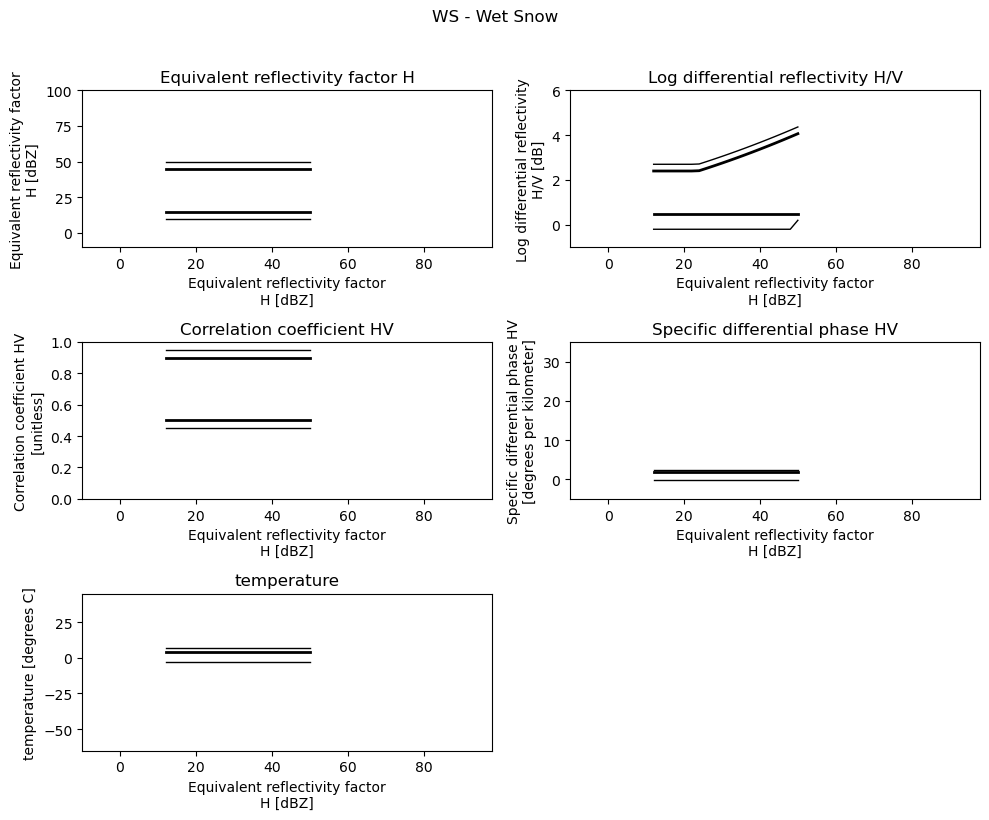

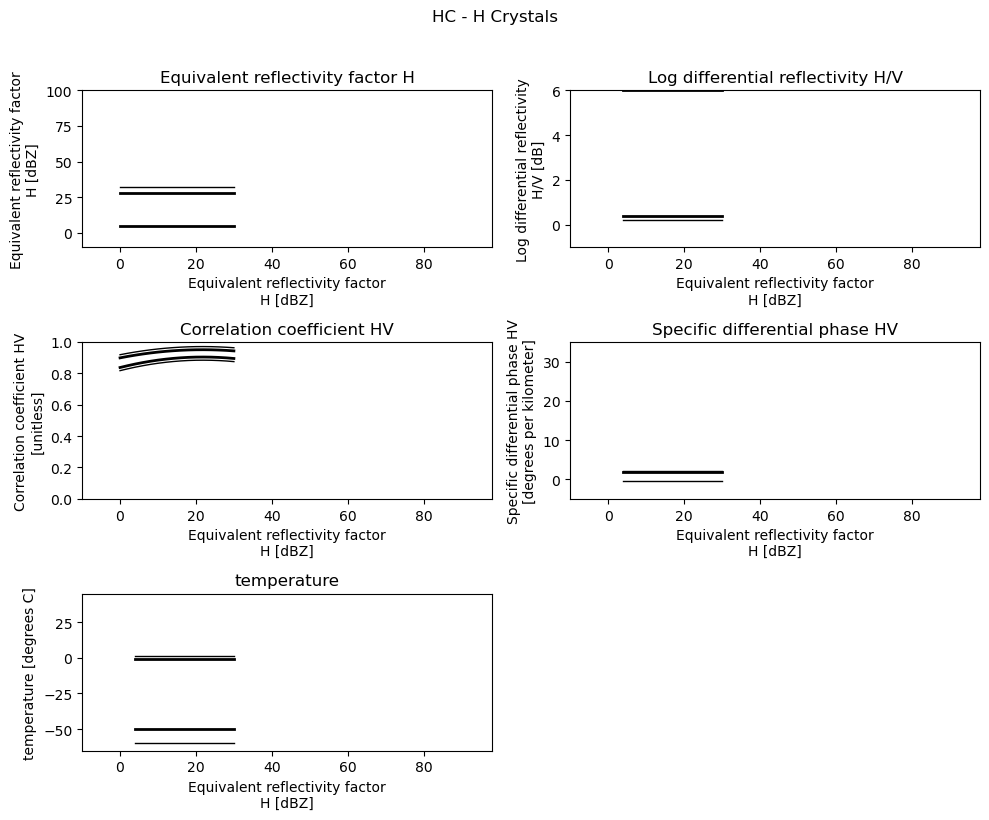

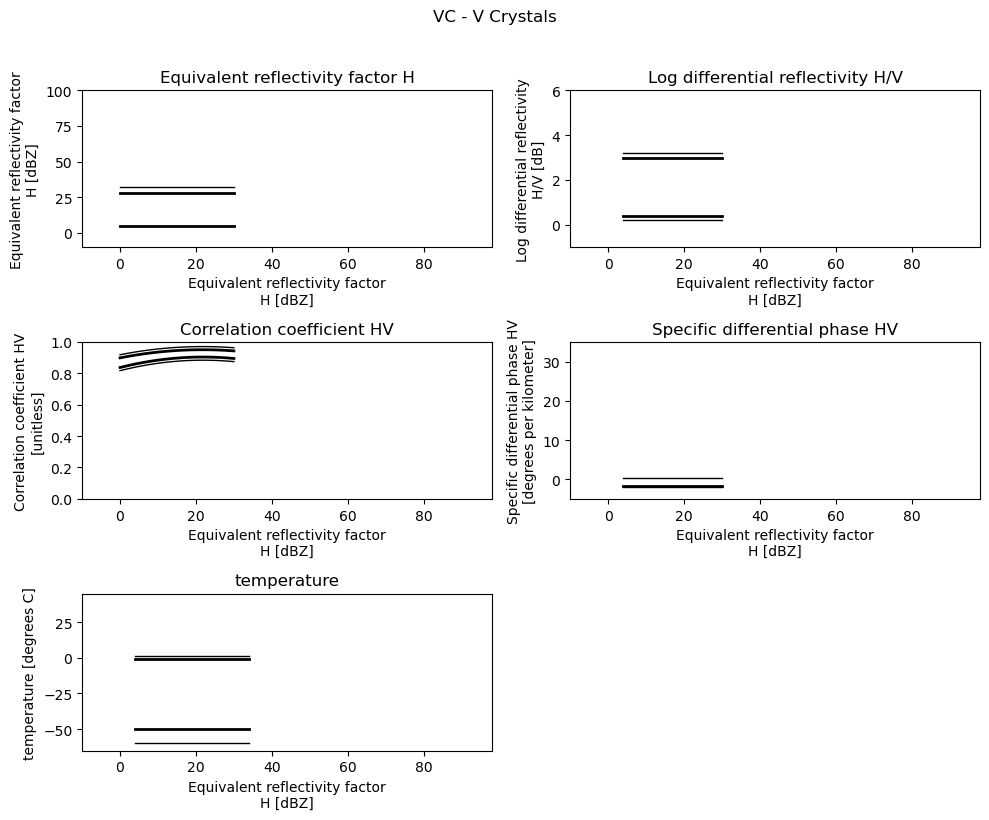

In [4]:
minmax = [(-10, 100), (-1, 6), (0.0, 1.0), (-5, 35), (-65, 45)]

for i, pr in enumerate(pr_types.values()):
    if pr[0] == "NP":
        continue
    fig = plt.figure(figsize=(10, 8))
    t = fig.suptitle(" - ".join(pr))
    t.set_y(1.02)
    hmc = msf.sel(hmc=pr[0])
    for k, p in enumerate(hmc.data_vars.values()):
        p = p.where(p != 0)
        ax = fig.add_subplot(3, 2, k + 1)
        p.sel(trapezoid=0).plot(x="idp", c="k", lw=1.0, ax=ax)
        p.sel(trapezoid=1).plot(x="idp", c="k", lw=2.0, ax=ax)
        p.sel(trapezoid=2).plot(x="idp", c="k", lw=2.0, ax=ax)
        p.sel(trapezoid=3).plot(x="idp", c="k", lw=1.0, ax=ax)
        ax.set_xlim((hmc.idp.min(), hmc.idp.max()))
        ax.margins(x=0.05, y=0.05)
        t = ax.set_title(f"{p.long_name}")
        ax.set_ylim(minmax[k])
    fig.tight_layout()
plt.show()

## Use Sounding Data

### Retrieve Sounding Data

To get the temperature as additional discriminator we use radiosonde data from
the [University of Wyoming](http://weather.uwyo.edu/upperair/sounding.html).

The function `get_radiosonde` tries to find the next next available radiosonde measurement on the given date.

In [5]:
rs_time = dt.datetime(2014, 6, 10, 12, 0)
import urllib

try:
    rs_data, rs_meta = wrl.io.get_radiosonde(10410, rs_time)
except (urllib.error.HTTPError, urllib.error.URLError):
    dataf = wrl.util.get_wradlib_data_file("misc/radiosonde_10410_20140610_1200.h5")
    rs_data, _ = wrl.io.from_hdf5(dataf)
    metaf = wrl.util.get_wradlib_data_file("misc/radiosonde_10410_20140610_1200.json")
    with open(metaf, "r") as infile:
        import json

        rs_meta = json.load(infile)
rs_meta

{'Station identifier': 'EDZE',
 'Station number': 10410,
 'Observation time': datetime.datetime(2014, 6, 10, 12, 0),
 'Station latitude': 51.4,
 'Station longitude': 6.97,
 'Station elevation': 147.0,
 'Showalter index': 1.65,
 'Lifted index': -5.85,
 'LIFT computed using virtual temperature': -6.24,
 'SWEAT index': 89.02,
 'K index': 23.7,
 'Cross totals index': 17.3,
 'Vertical totals index': 31.3,
 'Totals totals index': 48.6,
 'Convective Available Potential Energy': 1542.9,
 'CAPE using virtual temperature': 1644.44,
 'Convective Inhibition': -139.39,
 'CINS using virtual temperature': -79.9,
 'Equilibrum Level': 202.46,
 'Equilibrum Level using virtual temperature': 202.39,
 'Level of Free Convection': 736.36,
 'LFCT using virtual temperature': 773.09,
 'Bulk Richardson Number': 57.4,
 'Bulk Richardson Number using CAPV': 61.18,
 'Temp [K] of the Lifted Condensation Level': 288.22,
 'Pres [hPa] of the Lifted Condensation Level': 882.28,
 'Equivalent potential temp [K] of the LCL'

### Extract Temperature and Height

In [6]:
stemp = rs_data["TEMP"]
sheight = rs_data["HGHT"]
# remove nans
idx = np.isfinite(stemp)
stemp = stemp[idx]
sheight = sheight[idx]

### Create DataArray

In [7]:
stemp_da = xr.DataArray(
    data=stemp,
    dims=["height"],
    coords=dict(
        height=(["height"], sheight),
    ),
    attrs=dict(
        description="Temperature.",
        units="degC",
    ),
)
display(stemp_da)

<xarray.DataArray (height: 97)>
array([ 25.6,  19.8,  21.6,  21.6,  21.6,  19.7,  16.7,  16.4,  15.6,
        13.4,   5. ,   3.2,   1.8,  -5.3,  -6.7,  -9.3, -12.5, -14.9,
       -18.5, -18.9, -23.5, -25.5, -31.9, -32.7, -37. , -40.7, -41.9,
       -46.5, -50.5, -51.1, -60.7, -61.5, -65.7, -66.1, -64.1, -60.5,
       -59.1, -59.1, -59.4, -59.9, -60.4, -60.7, -58.5, -57.4, -55.5,
       -54.3, -54.9, -55.1, -55.3, -55.5, -55.9, -56.1, -55.4, -54.4,
       -53.4, -52.5, -52.7, -53.2, -55.6, -55.9, -55.5, -55.1, -54.9,
       -54.8, -54.6, -54.5, -54.3, -54.2, -54.2, -54.1, -53.9, -53.8,
       -52.5, -52.2, -51.8, -51.5, -50.7, -49.5, -48.9, -48.5, -48.6,
       -49.5, -49.7, -49.9, -49.1, -48.5, -47.6, -46.7, -45.8, -44.8,
       -43.9, -39.5, -37.3, -35.9, -36.1, -36.7, -35.5])
Coordinates:
  * height   (height) float64 147.0 744.0 828.0 ... 3.155e+04 3.228e+04
Attributes:
    description:  Temperature.
    units:        degC

### Interpolate to higher resolution

In [8]:
hmax = 30000.0
ht = np.arange(0.0, hmax)
itemp_da = stemp_da.interp({"height": ht})
display(itemp_da)

<xarray.DataArray (height: 30000)>
array([         nan,          nan,          nan, ..., -38.47842779,
       -38.47440585, -38.47038391])
Coordinates:
  * height   (height) float64 0.0 1.0 2.0 3.0 4.0 ... 3e+04 3e+04 3e+04 3e+04
Attributes:
    description:  Temperature.
    units:        degC

### Fix Temperature below first measurement

In [9]:
itemp_da = itemp_da.bfill(dim="height")

### Plot Temperature Profile

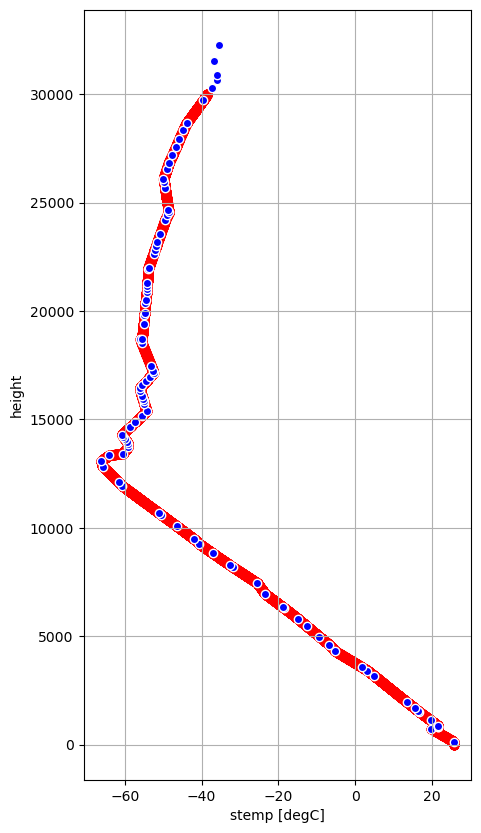

In [10]:
fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)
itemp_da.plot(y="height", ax=ax, marker="o", zorder=0, c="r")
stemp_da.to_dataset(name="stemp").plot.scatter(
    x="stemp", y="height", ax=ax, marker="o", c="b", zorder=1
)
ax.grid(True)

## Prepare Radar Data

### Load Radar Data

In [11]:
# read the radar volume scan
filename = "hdf5/2014-06-09--185000.rhi.mvol"
filename = wrl.util.get_wradlib_data_file(filename)

### Extract data for georeferencing

In [12]:
import xradar as xd

swp = xr.open_dataset(
    filename, engine=xd.io.backends.GamicBackendEntrypoint, group="sweep_0", chunks={}
)
swp = xd.util.remove_duplicate_rays(swp)
swp = xd.util.reindex_angle(
    swp, start_angle=0, stop_angle=90, angle_res=0.2, direction=1
)
swp

<xarray.Dataset>
Dimensions:            (range: 667, elevation: 450)
Coordinates:
  * range              (range) float32 37.5 112.5 187.5 ... 4.991e+04 4.999e+04
  * elevation          (elevation) float64 0.1 0.3 0.5 0.7 ... 89.5 89.7 89.9
    azimuth            (elevation) float64 dask.array<chunksize=(450,), meta=np.ndarray>
    time               (elevation) datetime64[ns] dask.array<chunksize=(450,), meta=np.ndarray>
    longitude          float64 ...
    latitude           float64 ...
    altitude           float64 ...
Data variables: (12/17)
    KDP                (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    PHIDP              (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    DBZH               (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    DBZV               (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    RHOHV              (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    DBTH               (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    ...                 ...
    ZDR                (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    sweep_mode         <U3 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

In [13]:
swp.azimuth.load(), swp.time.load()

(<xarray.DataArray 'azimuth' (elevation: 450)>
 array([225.        , 225.        , 225.        , 225.00549316,
        405.00549316, 225.00549316, 405.00549316, 225.        ,
        225.00549316, 225.01098633, 405.00549316, 225.00549316,
        405.00549316, 225.00549316, 225.01098633, 225.01098633,
        405.00549316, 225.00549316, 405.00549316, 225.        ,
        225.00549316, 225.01098633, 405.00549316, 225.00549316,
        225.01098633, 405.00549316, 225.        , 225.01098633,
        225.        , 225.        , 225.        , 225.        ,
        225.        , 225.        , 225.00549316, 225.01098633,
        405.00549316, 225.00549316, 225.01098633, 405.00549316,
        225.00549316, 405.00549316, 225.00549316, 225.00549316,
        405.00549316, 225.00549316, 405.00549316, 225.        ,
        225.00549316, 405.00549316, 225.        , 225.        ,
        225.00549316, 405.00549316, 225.00549316, 405.00549316,
        225.        , 225.        , 225.        , 225.   

In [14]:
swp.azimuth.values

array([225.        , 225.        , 225.        , 225.00549316,
       405.00549316, 225.00549316, 405.00549316, 225.        ,
       225.00549316, 225.01098633, 405.00549316, 225.00549316,
       405.00549316, 225.00549316, 225.01098633, 225.01098633,
       405.00549316, 225.00549316, 405.00549316, 225.        ,
       225.00549316, 225.01098633, 405.00549316, 225.00549316,
       225.01098633, 405.00549316, 225.        , 225.01098633,
       225.        , 225.        , 225.        , 225.        ,
       225.        , 225.        , 225.00549316, 225.01098633,
       405.00549316, 225.00549316, 225.01098633, 405.00549316,
       225.00549316, 405.00549316, 225.00549316, 225.00549316,
       405.00549316, 225.00549316, 405.00549316, 225.        ,
       225.00549316, 405.00549316, 225.        , 225.        ,
       225.00549316, 405.00549316, 225.00549316, 405.00549316,
       225.        , 225.        , 225.        , 225.        ,
       225.00549316, 225.        , 225.        , 225.  

### Get Heights of Radar Bins

In [15]:
swp = swp.wrl.georef.georeference()
swp.azimuth.values

array([225.        , 225.        , 225.        , 225.00549316,
       405.00549316, 225.00549316, 405.00549316, 225.        ,
       225.00549316, 225.01098633, 405.00549316, 225.00549316,
       405.00549316, 225.00549316, 225.01098633, 225.01098633,
       405.00549316, 225.00549316, 405.00549316, 225.        ,
       225.00549316, 225.01098633, 405.00549316, 225.00549316,
       225.01098633, 405.00549316, 225.        , 225.01098633,
       225.        , 225.        , 225.        , 225.        ,
       225.        , 225.        , 225.00549316, 225.01098633,
       405.00549316, 225.00549316, 225.01098633, 405.00549316,
       225.00549316, 405.00549316, 225.00549316, 225.00549316,
       405.00549316, 225.00549316, 405.00549316, 225.        ,
       225.00549316, 405.00549316, 225.        , 225.        ,
       225.00549316, 405.00549316, 225.00549316, 405.00549316,
       225.        , 225.        , 225.        , 225.        ,
       225.00549316, 225.        , 225.        , 225.  

### Plot RHI of Heights

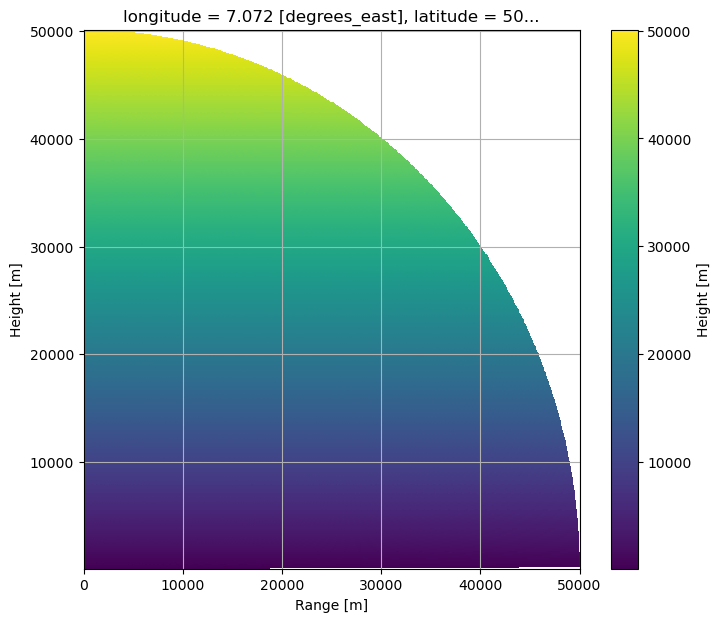

In [16]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
cmap = mpl.cm.viridis
swp.z.plot(x="gr", y="z", ax=ax, cbar_kwargs=dict(label="Height [m]"))
ax.set_xlabel("Range [m]")
ax.set_ylabel("Height [m]")
ax.grid(True)
plt.show()

### Get Index into High Res Height Array

In [17]:
def merge_radar_profile(rds, cds):
    cds = cds.interp({"height": rds.z}, method="linear")
    rds = rds.assign({"TEMP": cds})
    return rds

In [18]:
hmc_ds = swp.pipe(merge_radar_profile, itemp_da)
display(hmc_ds)

<xarray.Dataset>
Dimensions:            (range: 667, elevation: 450)
Coordinates: (12/15)
  * range              (range) float32 37.5 112.5 187.5 ... 4.991e+04 4.999e+04
  * elevation          (elevation) float64 0.1 0.3 0.5 0.7 ... 89.5 89.7 89.9
    azimuth            (elevation) float64 225.0 225.0 225.0 ... 225.0 225.0
    time               (elevation) datetime64[ns] 2014-06-09T18:50:01 ... 201...
    longitude          float64 7.072
    latitude           float64 50.73
    ...                 ...
    z                  (elevation, range) float64 99.63 99.76 ... 5.009e+04
    gr                 (elevation, range) float64 18.39 93.39 ... 67.49 67.62
    rays               (elevation, range) float64 0.1 0.1 0.1 ... 89.9 89.9 89.9
    bins               (elevation, range) float32 37.5 112.5 ... 4.999e+04
    crs_wkt            int64 0
    height             (elevation, range) float64 99.63 99.76 ... 5.009e+04
Data variables: (12/18)
    KDP                (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    PHIDP              (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    DBZH               (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    DBZV               (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    RHOHV              (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    DBTH               (elevation, range) float32 dask.array<chunksize=(450, 667), meta=np.ndarray>
    ...                 ...
    sweep_mode         <U3 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...
    TEMP               (elevation, range) float64 25.6 25.6 25.6 ... nan nan nan

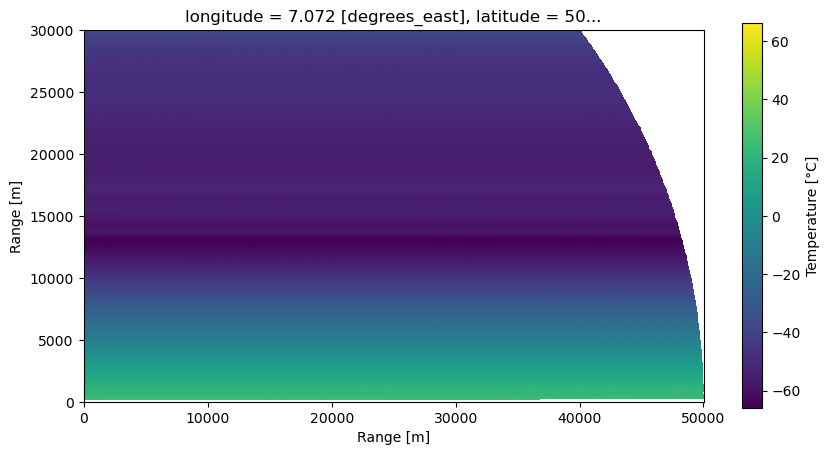

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
hmc_ds.TEMP.plot(
    x="gr",
    y="z",
    cmap=cmap,
    ax=ax,
    add_colorbar=True,
    cbar_kwargs=dict(label="Temperature [°C]"),
)
ax.set_xlabel("Range [m]")
ax.set_ylabel("Range [m]")
ax.set_aspect("equal")
ax.set_ylim(0, 30000)
plt.show()

## HMC Workflow

### Setup Independent Observable $Z_H$
Retrieve membership function values based on independent observable

In [20]:
%%time
msf_val = msf.wrl.classify.msf_index_indep(swp.DBZH)
display(msf_val)

<xarray.DataArray 'msf_index_indep' (hmc: 11, obs: 5, elevation: 450,
                                     range: 667, trapezoid: 4)>
dask.array<transpose, shape=(11, 5, 450, 667, 4), dtype=int32, chunksize=(11, 5, 450, 667, 4), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * hmc        (hmc) object 'LR' 'MR' 'HR' 'LD' 'HL' ... 'DS' 'WS' 'HC' 'VC'
  * obs        (obs) object 'ZH' 'ZDR' 'RHO' 'KDP' 'TEMP'
  * range      (range) float32 37.5 112.5 187.5 ... 4.991e+04 4.999e+04
  * elevation  (elevation) float64 0.1 0.3 0.5 0.7 0.9 ... 89.3 89.5 89.7 89.9
    azimuth    (elevation) float64 225.0 225.0 225.0 225.0 ... 225.0 225.0 225.0
    time       (elevation) datetime64[ns] 2014-06-09T18:50:01 ... 2014-06-09T...
    ...         ...
    y          (elevation, range) float64 -26.52 -79.55 -132.6 ... -61.25 -61.34
    z          (elevation, range) float64 99.63 99.76 ... 5.001e+04 5.009e+04
    gr         (elevation, range) float64 18.39 93.39 168.4 ... 67.49 67.62
    rays       (elevation, range) float64 0.1 0.1 0.1 0.1 ... 89.9 89.9 89.9
    bins       (elevation, range) float32 37.5 112.5 ... 4.991e+04 4.999e+04
    crs_wkt    int64 0
Dimensions without coordinates: trapezoid

CPU times: user 49.6 ms, sys: 0 ns, total: 49.6 ms
Wall time: 52.2 ms


### Fuzzyfication

In [21]:
%%time
fu = msf_val.wrl.classify.fuzzyfi(
    hmc_ds, dict(ZH="DBZH", ZDR="ZDR", RHO="RHOHV", KDP="KDP", TEMP="TEMP")
)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12 ms


### Probability

In [22]:
# weights dataset
w = xr.Dataset(dict(ZH=2.0, ZDR=1.0, RHO=1.0, KDP=1.0, TEMP=1.0))
display(w)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    ZH       float64 2.0
    ZDR      float64 1.0
    RHO      float64 1.0
    KDP      float64 1.0
    TEMP     float64 1.0

In [23]:
%%time
prob = fu.wrl.classify.probability(w).compute()
display(prob)

<xarray.DataArray (hmc: 11, elevation: 450, range: 667)>
array([[[0.16666667, 0.5       , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5       , 0.66666667, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5       , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16666667, 0.66666667, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.16666667, 0.66666667, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.16666667, 0.66666667, 0.5       , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.29812113, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.31296539, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.32917684, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ]],

       [[0.29480082, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.25280711, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.25808055, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.29812113, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.31296539, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.32917684, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ]]])
Coordinates: (12/16)
  * hmc        (hmc) object 'LR' 'MR' 'HR' 'LD' 'HL' ... 'DS' 'WS' 'HC' 'VC'
  * range      (range) float32 37.5 112.5 187.5 ... 4.991e+04 4.999e+04
  * elevation  (elevation) float64 0.1 0.3 0.5 0.7 0.9 ... 89.3 89.5 89.7 89.9
    azimuth    (elevation) float64 225.0 225.0 225.0 225.0 ... 225.0 225.0 225.0
    time       (elevation) datetime64[ns] 2014-06-09T18:50:01 ... 2014-06-09T...
    longitude  float64 7.072
    ...         ...
    z          (elevation, range) float64 99.63 99.76 ... 5.001e+04 5.009e+04
    gr         (elevation, range) float64 18.39 93.39 168.4 ... 67.49 67.62
    rays       (elevation, range) float64 0.1 0.1 0.1 0.1 ... 89.9 89.9 89.9
    bins       (elevation, range) float32 37.5 112.5 ... 4.991e+04 4.999e+04
    crs_wkt    int64 0
    height     (elevation, range) float64 99.63 99.76 ... 5.001e+04 5.009e+04

CPU times: user 1.24 s, sys: 1.11 s, total: 2.34 s
Wall time: 2.39 s


In [24]:
# prob = prob.compute()

### Classification

In [25]:
cl_res = prob.wrl.classify.classify(threshold=0.0)
display(cl_res)

<xarray.DataArray (hmc: 12, elevation: 450, range: 667)>
array([[[0.16666667, 0.5       , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5       , 0.66666667, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.5       , 0.5       , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16666667, 0.66666667, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.16666667, 0.66666667, 0.5       , ..., 0.        ,
         0.        , 0.        ],
        [0.16666667, 0.66666667, 0.5       , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.29812113, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.31296539, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ],
        [0.32917684, 0.33333333, 0.33333333, ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 1.        ,
         1.        , 1.        ],
        [0.        , 0.        , 0.        , ..., 1.        ,
         1.        , 1.        ],
        [0.        , 0.        , 0.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         1.        , 1.        ],
        [0.        , 0.        , 0.        , ..., 1.        ,
         1.        , 1.        ],
        [0.        , 0.        , 0.        , ..., 1.        ,
         1.        , 1.        ]]])
Coordinates: (12/16)
  * hmc        (hmc) object 'LR' 'MR' 'HR' 'LD' 'HL' ... 'WS' 'HC' 'VC' 'NP'
  * range      (range) float32 37.5 112.5 187.5 ... 4.991e+04 4.999e+04
  * elevation  (elevation) float64 0.1 0.3 0.5 0.7 0.9 ... 89.3 89.5 89.7 89.9
    azimuth    (elevation) float64 225.0 225.0 225.0 225.0 ... 225.0 225.0 225.0
    time       (elevation) datetime64[ns] 2014-06-09T18:50:01 ... 2014-06-09T...
    longitude  float64 7.072
    ...         ...
    z          (elevation, range) float64 99.63 99.76 ... 5.001e+04 5.009e+04
    gr         (elevation, range) float64 18.39 93.39 168.4 ... 67.49 67.62
    rays       (elevation, range) float64 0.1 0.1 0.1 0.1 ... 89.9 89.9 89.9
    bins       (elevation, range) float32 37.5 112.5 ... 4.991e+04 4.999e+04
    crs_wkt    int64 0
    height     (elevation, range) float64 99.63 99.76 ... 5.001e+04 5.009e+04

### Compute

In [26]:
%%time
cl_res = cl_res.compute()
cl_res = cl_res.assign_coords(sweep_mode="rhi")

CPU times: user 2.32 ms, sys: 290 µs, total: 2.61 ms
Wall time: 2.62 ms


## HMC Results

### Plot Probability of HMC Types

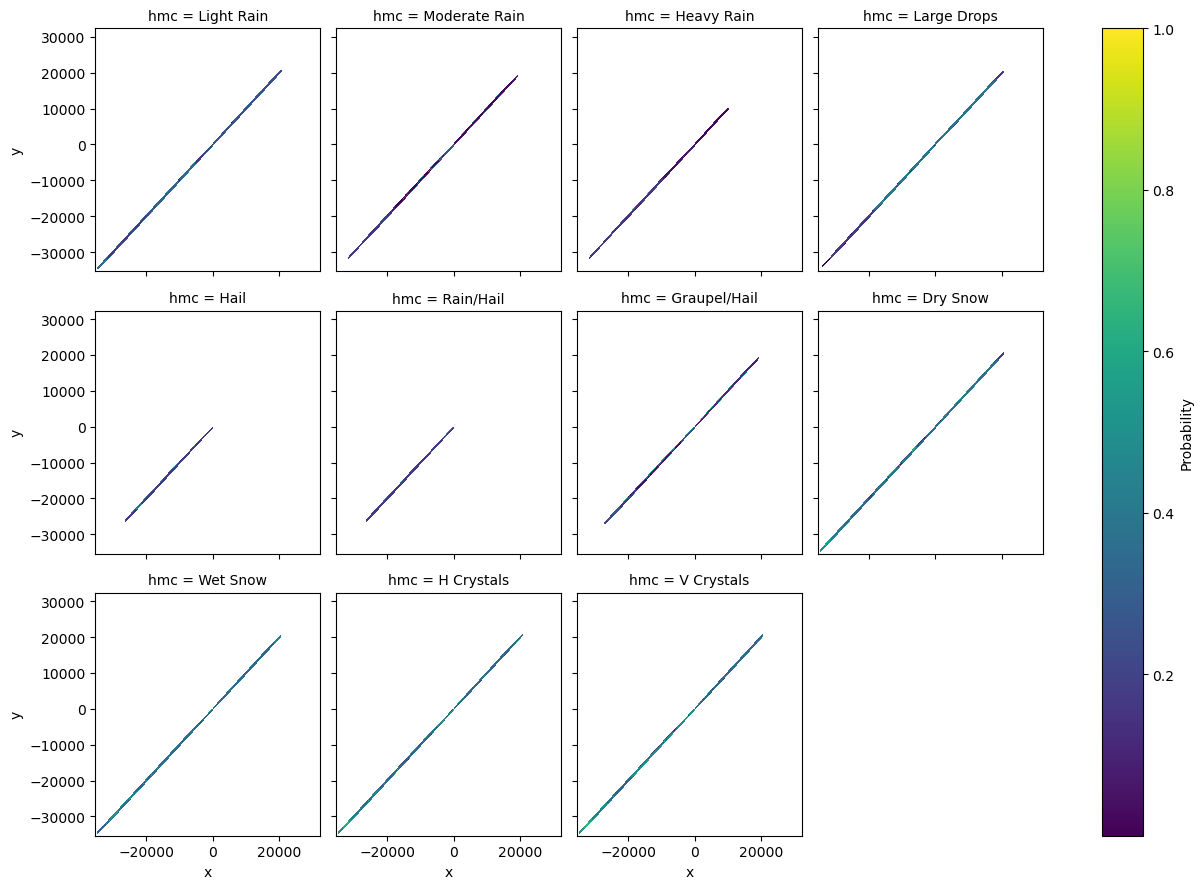

In [27]:
prob = prob.assign_coords(hmc=np.array(list(pr_types.values())).T[1][:11])
prob = prob.where(prob > 0)
prob.plot(x="x", y="y", col="hmc", col_wrap=4, cbar_kwargs=dict(label="Probability"))

### Plot maximum  probability 

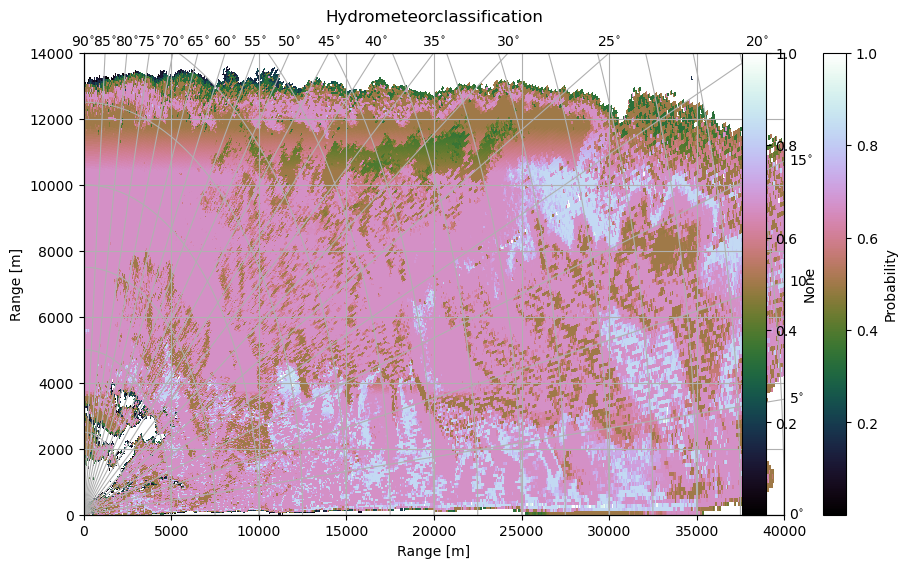

In [28]:
fig = plt.figure(figsize=(10, 6))
cmap = "cubehelix"
im = cl_res.max("hmc").wrl.vis.plot(
    ax=111,
    crs={"angular_spacing": 20.0, "radial_spacing": 12.0, "latmin": 2.5},
    cmap=cmap,
    fig=fig,
)
cgax = plt.gca()
cbar = plt.colorbar(im, ax=cgax, fraction=0.046, pad=0.05)
cbar.set_label("Probability")
cgax.set_xlim(0, 40000)
cgax.set_ylim(0, 14000)
t = cgax.set_title("Hydrometeorclassification", y=1.05)

caax = cgax.parasites[0]
caax.set_xlabel("Range [m]")
caax.set_ylabel("Range [m]")
plt.show()

### Plot classification result

In [29]:
bounds = np.arange(-0.5, prob.shape[0] + 0.6, 1)
ticks = np.arange(0, prob.shape[0] + 1)
cmap = mpl.cm.get_cmap("cubehelix", len(ticks))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [30]:
hydro = cl_res.argmax("hmc")
hydro.attrs = dict(long_name="Hydrometeorclassification")
hydro = hydro.assign_coords(sweep_mode="rhi")

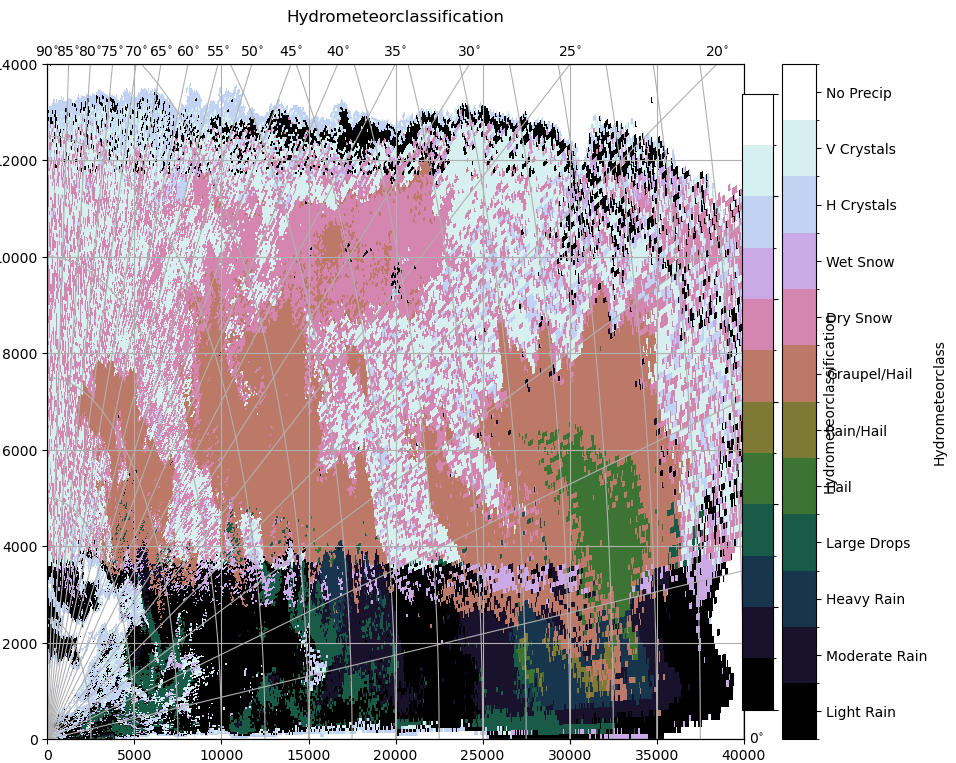

In [31]:
fig = plt.figure(figsize=(10, 8))
im = hydro.wrl.vis.plot(
    ax=111,
    crs={"angular_spacing": 20.0, "radial_spacing": 12.0, "latmin": 2.5},
    norm=norm,
    cmap=cmap,
    fig=fig,
)
cgax = plt.gca()
caax = cgax.parasites[0]
paax = cgax.parasites[1]

cbar = plt.colorbar(im, ticks=ticks, ax=cgax, fraction=0.046, norm=norm, pad=0.05)
cbar.set_label("Hydrometeorclass")
caax.set_xlabel("Range [km]")
caax.set_ylabel("Range [km]")
labels = [pr_types[i][1] for i, _ in enumerate(pr_types)]
labels = cbar.ax.set_yticklabels(labels)
t = cgax.set_title("Hydrometeorclassification", y=1.05)
cgax.set_xlim(0, 40000)
cgax.set_ylim(0, 14000)
plt.tight_layout()